Here’s a Python guide to building an image detection model for friendship sloops. This example uses the TensorFlow library with a simple CNN approach and OpenCV for image preprocessing. You may need to adapt based on your dataset and model requirements.

In [ ]:
%pip install tensorflow
%pip install opencv-python

In [2]:
from random import randrange
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
import cv2
import os
import pprint
from pathlib import Path
from dotenv import load_dotenv

# Suppress only the single warning from urllib3.
import urllib3
urllib3.disable_warnings(category=urllib3.exceptions.InsecureRequestWarning)

# Load environment variables from the .env file (if present)
load_dotenv()

# Define the config class
class CFG:

    # Define the directory to store the images
    DATA_DIR = Path(os.environ['DATA_DIR'])
    
    # Set the number of batchs for processing
    BATCH_SIZE = int(os.environ['BATCH_SIZE'])

    # Epocs for model training
    NUM_EPOCHS = int(os.environ['NUM_EPOCHS'])
    
    MODEL_PATH = Path(os.environ['MODEL_PATH'])
    
pprint.pprint(CFG.__dict__)

mappingproxy({'BATCH_SIZE': 32,
              'DATA_DIR': PosixPath('data'),
              'MODEL_PATH': PosixPath('saved_model/friendship_sloop_detector'),
              'NUM_EPOCHS': 10,
              '__dict__': <attribute '__dict__' of 'CFG' objects>,
              '__doc__': None,
              '__module__': '__main__',
              '__weakref__': <attribute '__weakref__' of 'CFG' objects>})


## 1. Import Libraries and Prepare Data

In [3]:
# Set up directories
data_dir = CFG.DATA_DIR
img_size = 224 # 128  # Adjust based on image size
batch_size = CFG.BATCH_SIZE

# Data Augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # Split for training/validation
    horizontal_flip=True,
    rotation_range=15,
    zoom_range=0.2,
    shear_range=0.2
)

train_gen = datagen.flow_from_directory(
    data_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    data_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

# Load ResNet50 with pretrained weights and exclude top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

print(f'Made: {x}')


Found 262 images belonging to 2 classes.
Found 65 images belonging to 2 classes.
Made: <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_177>


## 2. Show sample of the loaded images

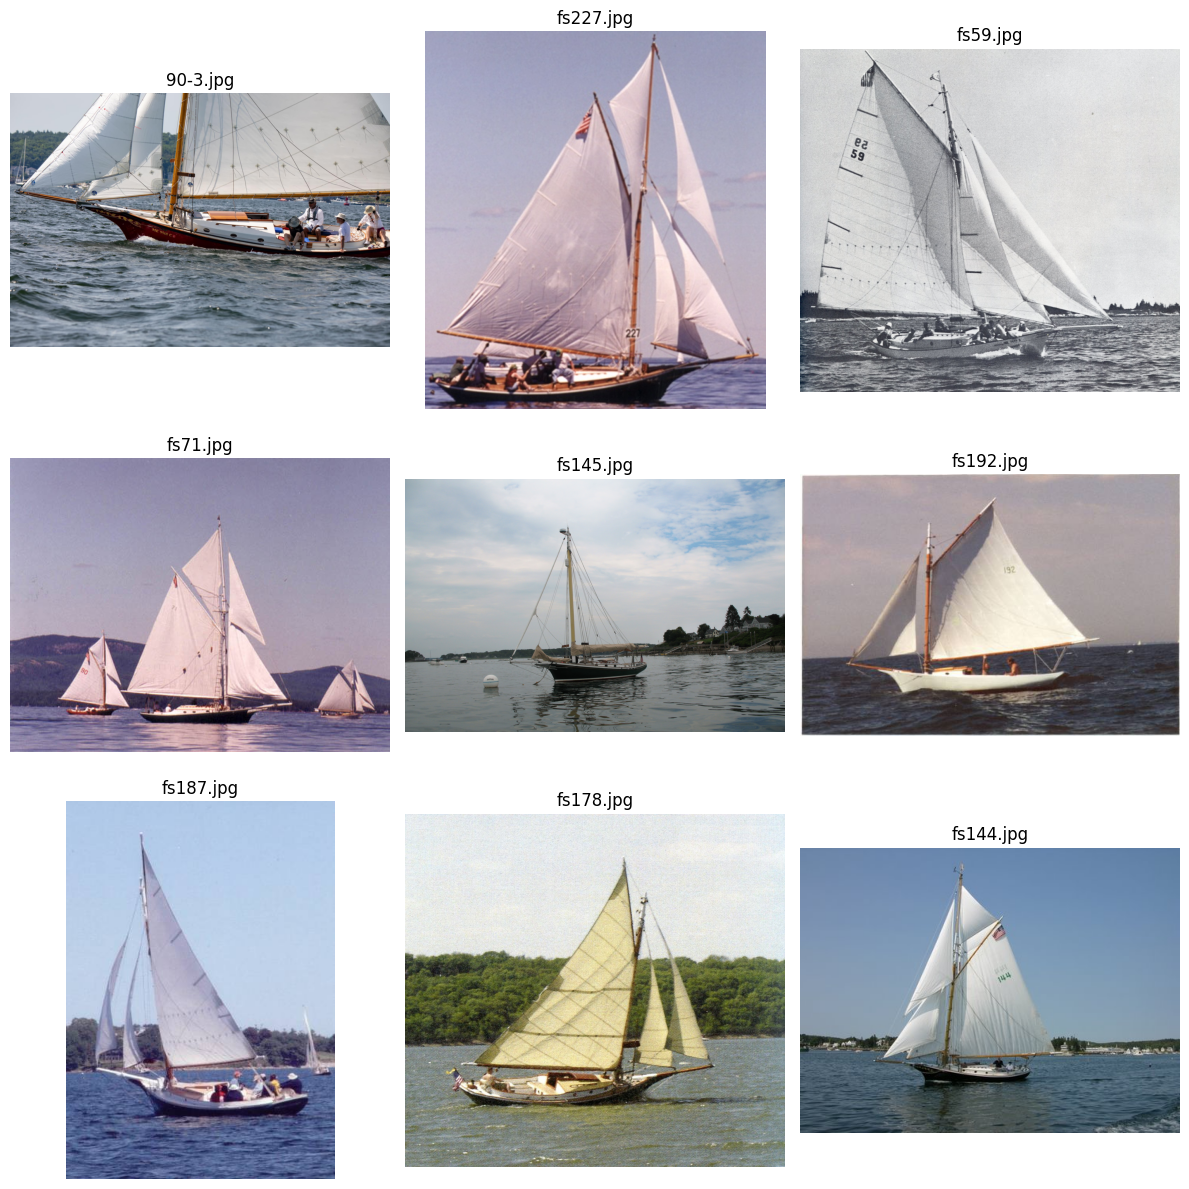

In [4]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Get a list of image file paths
dir = CFG.DATA_DIR / 'train/friendship_sloop'

image_files = [os.path.join(dir, f) for f in os.listdir(dir) if f.endswith('.jpg') or f.endswith('.png')]

# Display a 3x3 grid of images
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()

for img_path, ax in zip(image_files[:9], axes):
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(os.path.basename(img_path))

plt.tight_layout()
plt.show()

## 3. Build the Model


In [5]:
model = Model(inputs=base_model.input, outputs=x)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

## 4. Train the Model


In [6]:
history = model.fit(
    train_gen,
    epochs=CFG.NUM_EPOCHS,
    validation_data=val_gen
)
print(f"Training completed.")

/Users/dennis/Documents/Projects/isitafriendship/venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8838 - loss: 0.3723

/Users/dennis/Documents/Projects/isitafriendship/venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.8828 - loss: 0.3745 - val_accuracy: 0.8769 - val_loss: 0.3852
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.8817 - loss: 0.3741 - val_accuracy: 0.8769 - val_loss: 0.3832
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.8870 - loss: 0.3490 - val_accuracy: 0.8769 - val_loss: 0.3724
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.8755 - loss: 0.3708 - val_accuracy: 0.8769 - val_loss: 0.3790
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.8752 - loss: 0.3928 - val_accuracy: 0.8769 - val_loss: 0.3834
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.8724 - loss: 0.3893 - val_accuracy: 0.8769 - val_loss: 0.3804
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.8670 - loss: 0.3966 - val_accuracy: 0.8769 - val_loss: 0.3775
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.8584 - loss: 0.4113 - val_accuracy: 0.8769 - val_loss: 0.3679
Epoch 9/10
9/9 ━━━━

## 5. Evaluate and Save the Model

In [9]:
loss, accuracy = model.evaluate(val_gen)
print(f"Validation Accuracy: {accuracy}")
print(f"Validation Loss: {loss}")

# Create the base directory if it doesn't exist
base_dir = CFG.MODEL_PATH.parent
os.makedirs(base_dir, exist_ok=True)

# Save model
outfile = f'{CFG.MODEL_PATH}.keras'
model.save(outfile)
print(f'saved { os.path.getsize(outfile) } bytes to {outfile}')


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 917ms/step - accuracy: 0.8760 - loss: 0.3822
Validation Accuracy: 0.8769230842590332
Validation Loss: 0.3818359076976776
saved 98155253 bytes to saved_model/friendship_sloop_detector.keras


## 6. Model Testing on New Images

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (img_size, img_size))
    img = img / 255.0
    img = img.reshape(-1, img_size, img_size, 3)
    return img

# Predict
# Directory containing test images
test_image_dir = 'images/prediction'

# Iterate over all images in the directory
for filename in os.listdir(test_image_dir):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        test_image_path = os.path.join(test_image_dir, filename)
        
        # Show the test image
        plt.imshow(Image.open(test_image_path))
        plt.axis('off')
        plt.show()

        # Preprocess and predict
        img = preprocess_image(test_image_path)
        prediction = model.predict(img)

        print(f"Prediction for {filename}: {prediction}")
        if prediction[0][0] > 0.5:
            print("Friendship Sloop detected")
        else:
            print("No Friendship Sloop detected")

